# How do we know when a side walk is completely wet? #

**Model raindrops falling on a sidewalk (sidewalk is 1m and raindrops are 1cm). How could we know when the sidewalk is completely wet? [Question 27](https://www.inc.com/business-insider/google-hardest-interview-questions.html)**

## Assumptions ##

We can assume this question is talking about a 1m by 1m square of sidewalk and each drop is always exactly 1cm squared. When each drop falls on the sidewalk it will fall in a grid like pattern never overlapping with a different square centimeter cell of the sidewalk, although drops could fall on the same cells multiple times. We will also assume that the drops never dry up.

## Breaking down the problem ##

Alhough assuming the sidewalk is square we can begin to tackle the problem by instead assuming we talking about a single 2 dimensional strip of sidewalk. We can look at this problem from the perscpective of probability, so we can rephrase the question as so...

**Whats the chance the sidewalk of M units is completely wet after N drops have fallen (assuming 1 drop is 1 unit)?**

We can create an emulation to give us some ideas on what probabilites our solution should produce...

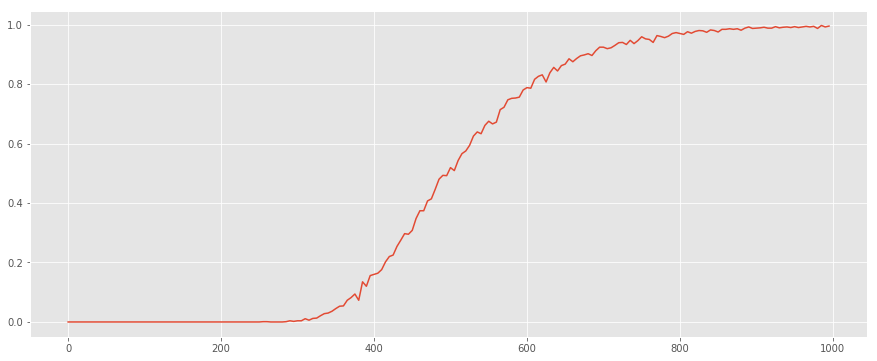

In [316]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6

def emulate(n, M):
    spots = [False] * M
    
    for _ in range(n):
        i = np.random.randint(0, M)
        spots[i] = True
        
    return all(spots)


def average_emulate(n, M, attempts=1000):
    count = 0
    for _ in range(attempts):
        if emulate(n, M):
            count += 1
    return count / attempts


X = np.arange(0, 1000, 5)
Y = [average_emulate(x, 100) for x in X]

plt.plot(X, Y)
plt.show()

## Assertions ##

We can define the question as the function **P(M,N)** which will return a value between **\[0, 1\]**.

Firstly we can make some logical assertions that we can visually observe in our emulation:
- When the number of drops is less than the number of units it's impossible for the sidewalk to be completely covered: **When N < M, P(M,N) = 0**
- It will take **atleast M** number of drops to completely cover the sidewalk: **When N >= M, P(M,N) > 0**
- It is impossible to ever be 100% certain the sidewalk is covered: **As N -> Infinity, P(M,N) -> 1**

The first two assertions are quite straightforward but we will need to dive a little deeper into the third....

## The short answer - we never know for sure ##

Our final assertion suggests that we will never be able to state with 100% confidence that our sidewalk is completely wet. We must consider multiple raindrops falling in the same spot. When a raindrop falls in a spot that has already been wet we will refer to this as a **collision**. The fact that collisions can occur means that no matter how many raindrops fall on the sidewalk each raindrop could fall on an already wet spot causing a collision instead of hitting a vacant spot.

Imagine flipping a coin until you got heads theres a chance that every flip could result in tails, not once ever landing on heads - despite the [Gambler's Fallacy](https://en.wikipedia.org/wiki/Gambler%27s_fallacy). The same thing could happen with each **independant** drop and the vacant drops required to be hit to completely cover our sidewalk may constantly be missed as collisions occur instead.

## Birthday Paradox ##

For cryptographers, probability theroists and computer scientest alike when you read collisions or even at first glance of the question your train of thought was likely all stations to the [Birthday Paradox](https://en.wikipedia.org/wiki/Birthday_problem). Wikipedia explains the Birthday Paradox as follows:

_In probability theory, the birthday problem or birthday paradox concerns the probability that, in a set of n randomly chosen people, some pair of them will have the same birthday. By the pigeonhole principle, the probability reaches 100% when the number of people reaches 367 (since there are only 366 possible birthdays, including February 29). However, 99.9% probability is reached with just 70 people, and 50% probability with 23 people. These conclusions are based on the assumption that each day of the year (excluding February 29) is equally probable for a birthday._

We can observe this below.

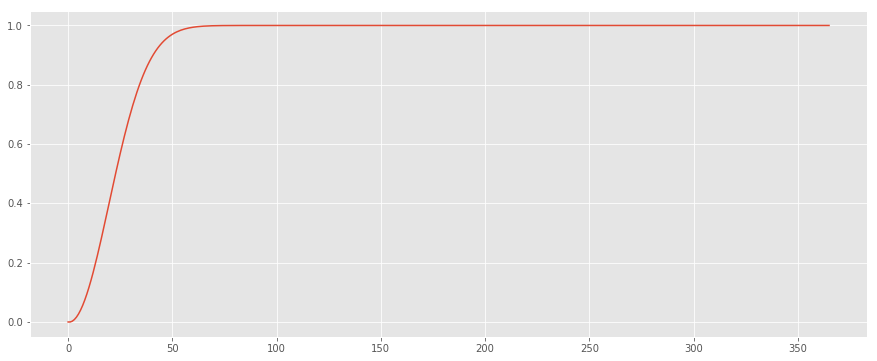

In [312]:
import operator as op
from functools import reduce
from decimal import *
getcontext().prec = 200

def birthday_collision(n):
    if n <= 0:
        return 0
    return 1 - reduce(op.mul, (Decimal(365 - x) / 365 for x in range(n)))

X = np.arange(366)
Y = [birthday_collision(x) * 1 for x in X]

plt.plot(X, Y)
plt.show()

So the birthday paradox shows us the chance of collisions between two people sharing a birthday, we can map this to our sidewalk problem by picturing the possible number of spots we have on the sidewalk as the amount of days in a year and the amount of rain drops being the amount of people in our sample. For the birthday paradox our M was 365, we can rewrite our function to be used for the sidewalk problem with this in mind.

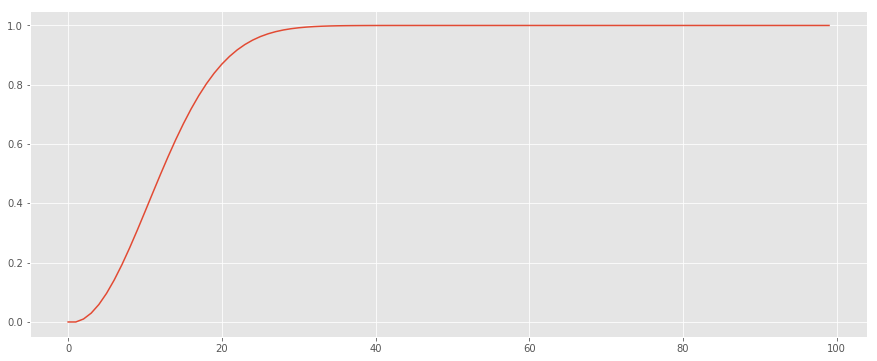

In [313]:
def collision(n, M=100):
    if n <= 0:
        return 0
    return 1 - reduce(op.mul, (Decimal(M - x) / M for x in range(n)))

X = np.arange(100)
Y = [collision(x) for x in X]

plt.plot(X, Y)
plt.show()

We can see that after just 30 drops the chance that two drops have collided is **almost** certain.

So what does this mean for our problem? We know that we need atleast 100 drops to fall for there to be a chance that our 1m (100cm) 2D strip of sidewalk is completely covered. But for the exact minimum of 100 drops to fall and our sidewalk has been completely covered not a single collision must have occured. We can observe the probability of no collisions occuring by simply taking the complement of our collision function.

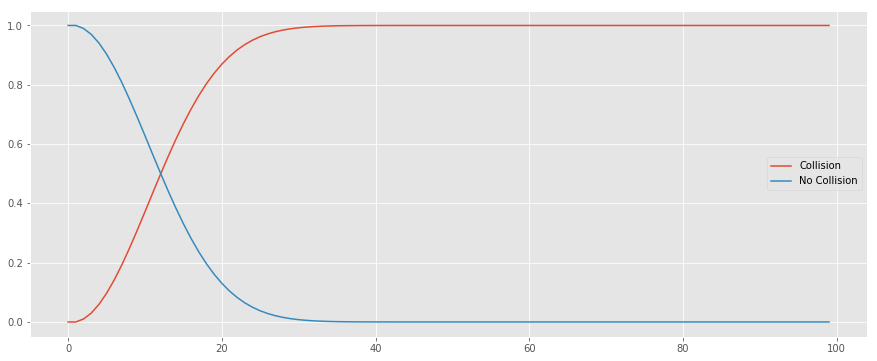

In [317]:
def no_collision(n, **kwargs):
    return 1 - collision(n, **kwargs)

X = np.arange(100)
Y1 = [collision(x) for x in X]
Y2 = [no_collision(x) for x in X]

plt.plot(X, Y1)
plt.plot(X, Y2)
plt.legend(["Collision", "No Collision"])
plt.show()

### The chance exactly 100 raindrops will cover the sidewalk ###

In [150]:
n = 100
p = no_collision(n)

print("No collisions after %d raindrops: %e%%" % (n, p * 100))

No collisions after 100 raindrops: 9.332622e-41%


For a bit of a better idea of just how many leading zeros are in that probability...

In [326]:
print("That's a chance of about %.42f out of 1 (not very much)." % (p * 100))

That's a chance of about 0.000000000000000000000000000000000000000093 out of 1 (not very much).


## What we can conclude so far ##

So we know there's no way the sidewalk can be completely wet before 100 drops have fallen, and we know once 100 drops have fallen theres a very very very unlikely chance that the sidewalk is completely wet.

But for each amount of raindrops after 100 the chance will keep increasing as we know that as N -> infinity then P(M, N) approaches 1. When N was 100 that meant we must have had 0 collisions, but when N is 101 it means we must have at most 1 collision and our sidewalk would still be entirely covered, when N is two we know could have at most 2 collisions...

** TO BE CONTINUED **

In [309]:
# we might need this...
def choose(n, k):
    if not (0 <= k <= n):
        return 0
    return Decimal(factorial(n) / (factorial(k) * factorial(n - k)))


def wet_sidewalk(n, M=100):
    return 0 # TODO: ...